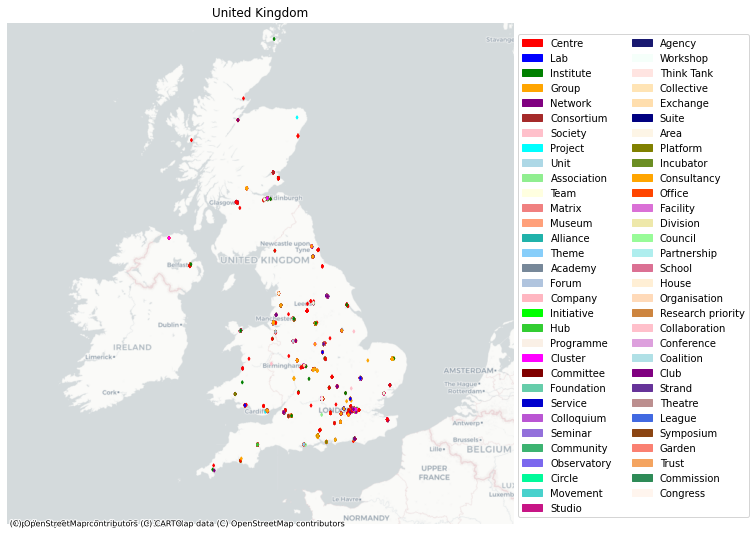

In [1]:
import pyproj
import math
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
from contextily import Place
import matplotlib.patches as mpatches

mhp2 = pd.read_csv('OneDrive/Digital Training/MHP/tbl_INFRASTRUCTURES-Grid view August 2023.csv')

# Convert the latitude and longitude columns to numeric data, coerce errors to NaN
mhp2['Latitude'] = pd.to_numeric(mhp2['Latitude'], errors='coerce')
mhp2['Longitude'] = pd.to_numeric(mhp2['Longitude'], errors='coerce')

# Replace NaN values in the 'Type of infrastructure' column with a specific string
mhp2['Type of infrastructure'] = mhp2['Type of infrastructure'].fillna('Missing')

# Drop any rows with NaN values in the latitude or longitude columns
mhp2 = mhp2.dropna(subset=['Latitude', 'Longitude'])

# Drop any rows with 'Missing' or 'NA' values in the 'Type of infrastructure' column
mhp2 = mhp2.loc[~mhp2['Type of infrastructure'].isin(['Missing', 'NA'])]

latitudes = mhp2['Latitude']
longitudes = mhp2['Longitude']
types = mhp2['Type of infrastructure']

# Create a dictionary mapping each type of infrastructure to a color
type_colors = {
    'Centre': 'red', 'Lab': 'blue', 'Institute': 'green', 'Group': 'orange',
    'Network': 'purple', 'Consortium': 'brown', 'Society': 'pink', 'Project': 'cyan',
    'Unit': 'lightblue', 'Association': 'lightgreen', 'Team': 'lightyellow', 'Matrix': 'lightcoral',
    'Museum': 'lightsalmon', 'Alliance': 'lightseagreen', 'Theme': 'lightskyblue',
    'Academy': 'lightslategrey', 'Forum': 'lightsteelblue', 'Company': 'lightpink',
    'Initiative': 'lime', 'Hub': 'limegreen', 'Programme': 'linen', 'Cluster': 'magenta',
    'Committee': 'maroon', 'Foundation': 'mediumaquamarine', 'Service': 'mediumblue',
    'Colloquium': 'mediumorchid', 'Seminar': 'mediumpurple', 'Community': 'mediumseagreen',
    'Observatory': 'mediumslateblue', 'Circle': 'mediumspringgreen', 'Movement': 'mediumturquoise',
    'Studio': 'mediumvioletred', 'Agency': 'midnightblue', 'Workshop': 'mintcream',
    'Think Tank': 'mistyrose', 'Collective': 'moccasin', 'Exchange': 'navajowhite',
    'Suite': 'navy', 'Area': 'oldlace', 'Platform': 'olive', 'Incubator': 'olivedrab',
    'Consultancy': 'orange', 'Office': 'orangered', 'Facility': 'orchid', 'Division': 'palegoldenrod',
    'Council': 'palegreen', 'Partnership': 'paleturquoise', 'School': 'palevioletred',
    'House': 'papayawhip', 'Organisation': 'peachpuff', 'Research priority': 'peru',
    'Collaboration': 'pink', 'Conference': 'plum', 'Coalition': 'powderblue', 'Club': 'purple',
    'Strand': 'rebeccapurple', 'Theatre': 'rosybrown', 'League': 'royalblue', 'Symposium': 'saddlebrown',
    'Garden': 'salmon', 'Trust': 'sandybrown', 'Commission': 'seagreen', 'Congress': 'seashell',
    'Missing': 'lightgrey',  # For NaN values
    'NA': 'grey',
}

# Remove the entries for 'Missing' and 'NA' from the type_colors dictionary
del type_colors['Missing']
del type_colors['NA']

# Create a list of colors corresponding to each point in your dataset
colors = [type_colors.get(infrastructure_type, 'black') for infrastructure_type in types]

uk = Place('United Kingdom')
ax = uk.plot()
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3857")

valid_points = [(lat, lon) for lat, lon in zip(latitudes, longitudes) if not math.isnan(lat) and not math.isnan(lon)]
x, y = zip(*[transformer.transform(lat, lon) for lat, lon in valid_points])

# Use the colors list as the c parameter in the scatter function
ax.scatter(x, y, marker='d', c=colors, s=5)

# Define the latitude and longitude of the center of the UK
uk_center_lat = 54.3781
uk_center_lon = -3.4360

# Define the zoom level
zoom_level = 1000000  # Change this value to adjust the zoom level

# Transform the center coordinates to Web Mercator
uk_center_x, uk_center_y = transformer.transform(uk_center_lat, uk_center_lon)

# Create a list of patches for the legend
legend_patches = []

for infrastructure_type, color in type_colors.items():
    patch = mpatches.Patch(color=color, label=infrastructure_type)
    legend_patches.append(patch)

# Place the legend outside the plot area, to the right of the plot
# Split the legend into multiple columns
# Change the font size of the legend
ax.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, fontsize='medium')

# Set the limits of the x-axis and y-axis
ax.set_xlim(uk_center_x - zoom_level, uk_center_x + zoom_level)
ax.set_ylim(uk_center_y - zoom_level, uk_center_y + zoom_level)

# Make the figure larger so that the legend fits
fig = plt.gcf()
fig.set_size_inches(15, 8)

# Adjust the layout
plt.tight_layout()

plt.show()

In [2]:
import ipywidgets as widgets

# Create a function to plot the data based on selected types of infrastructure
def plot_data(selected_types):
    plt.figure(figsize=(10, 6))
    
    ax = uk.plot()
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

    filtered_points = [(lat, lon, t) for lat, lon, t in zip(latitudes, longitudes, types) if t in selected_types]
    filtered_colors = [type_colors[t] for _, _, t in filtered_points]
    x, y = zip(*[transformer.transform(lat, lon) for lat, lon, _ in filtered_points])

    ax.scatter(x, y, marker='d', c=filtered_colors, s=5)

    legend_patches = [mpatches.Patch(color=color, label=infrastructure_type) for infrastructure_type, color in type_colors.items() if infrastructure_type in selected_types]

    ax.legend(handles=legend_patches, loc='upper left', fontsize='large')

    ax.set_xlim(uk_center_x - zoom_level, uk_center_x + zoom_level)
    ax.set_ylim(uk_center_y - zoom_level, uk_center_y + zoom_level)

    plt.tight_layout()
    plt.show()

# Create an interactive version of the plot
interactive_plot = widgets.interactive(plot_data, selected_types=widgets.SelectMultiple(
    options=type_colors.keys(),
    value=list(type_colors.keys()),
    description='Types',
    disabled=False
))

display(interactive_plot)

interactive(children=(SelectMultiple(description='Types', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,…

In [3]:
# saving the widgeted map in HTML (doesnt work - it's been deactivated)

# from ipywidgets import embed
# embed.embed_minimal_html('OneDrive/Digital Training/MHP/widgetedmap.html', views=[interactive_plot], state=embed.dependency_state([interactive_plot]))

In [4]:
# Voila method
!pip install voila --user

In [5]:
!jupyter serverextension enable voila --sys-prefix

Enabling: voila
- Writing config: C:\Users\Dragh\anaconda3\etc\jupyter
    - Validating...
      voila 0.5.2 ok


In [ ]:
!jupyter notebook